# Getting Started

## General Tips
In each homework problem, you will implement autoregressive models and run it on various datasets. Oftentime you will run it on two datasets (dataset 1 and dataset 2). In these cases, the expected outputs for dataset 1 are already provided to help as a sanity check.

Feel free to print whatever output (e.g. debugging code, training code, etc) you want, as the graded submission will be the submitted html with images.

There is a lot of freedom in this homework to write and design your own models. Hyperparameters are given as a guide to show what worked for us, but feel free to explore and use what you find is best!

Run the cells below to download and load up the starter code.

In [1]:
# # get to the parent dir of mai_dul repo
import os


# 
# os.chdir('../../')
os.getcwd()

'/home/ordem/PycharmProjects/MAI_DUL_WS24/homeworks/hw1'

In [2]:
# # run only once at the beginning of working on hw1
# !unzip -qq homeworks/hw1/data/hw1_data.zip -d homeworks/hw1/data/
# 
# # install latest version deepul package
# !pip install -e .

In [3]:

from deepul.hw1_helper import (
    # Q1
    visualize_q1_data,
    q1_save_results,
)

import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader



# Question 1: 1D Data

In this question, we will train simple generative models on discrete 1D data.

Execute the cell below to visualize our datasets

Dataset 1


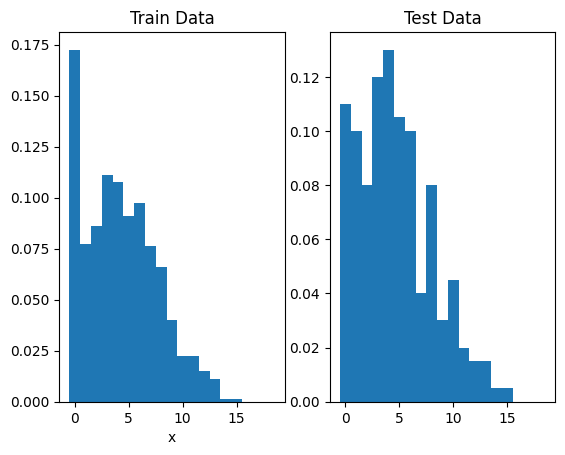

Dataset 2


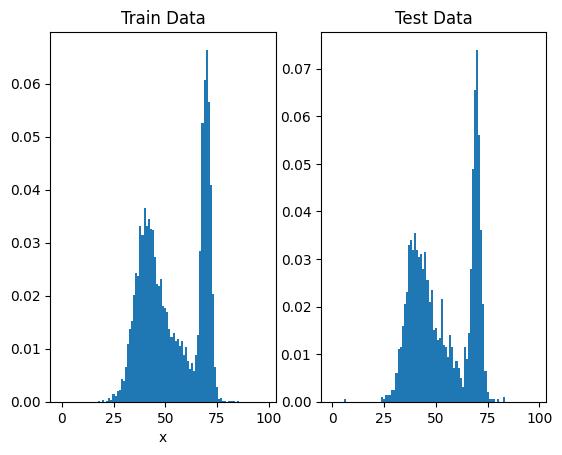

In [4]:
visualize_q1_data(dset_type=1)
visualize_q1_data(dset_type=2)

## Part (a) Fitting a Histogram

Let $\theta = (\theta_0, \dots, \theta_{d-1}) \in \mathbb{R}^{d}$ and define the model $p_\theta(x) = \frac{e^{\theta_x}}{\sum_{x'}e^{\theta_{x'}}}$

Fit $p_\theta$ with maximum likelihood via stochastic gradient descent on the training set, using $\theta$ initialized to zero. Use your favorite version of stochastic gradient descent, and optimize your hyperparameters on a validation set of your choice.

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. Plot the model probabilities in a bar graph with $\{0,\dots,d-1\}$ on the x-axis and a real number in $[0,1]$ on the y-axis.




Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [5]:
def q1_a(train_data, test_data, d, dset_id):
    """
    train_data: An (n_train,) numpy array of integers in {0, ..., d-1}
    test_data: An (n_test,) numpy array of integers in {0, .., d-1}
    d: The number of possible discrete values for random variable x
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
               used to set different hyperparameters for different datasets
  
    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (d,) of model probabilities
    """

    train_losses = []
    test_losses = []
    theta = np.zeros((d,))
    n_train = train_data.shape[0]
    n_test = test_data.shape[0]

    p_theta = np.exp(theta) / np.sum(np.exp(theta))
    test_loss = (-1 / n_test) * np.sum(np.log(p_theta[test_data]))
    test_losses.append(test_loss)

    max_epochs = 200
    lr = 0.01
    batch_size = 128

    for epoch in range(max_epochs):
        for batch in np.array_split(train_data[np.random.permutation(n_train)], batch_size):
            train_batch_loss = (-1 / batch.size) * np.sum(np.log(p_theta[batch]))
            train_losses.append(train_batch_loss)

            x_thetas = np.tile(np.arange(d), (batch.size, 1))
            d_theta = (-1 / batch.size) * np.sum(
                np.where(x_thetas == batch.reshape((batch.size, 1)),
                         1 - p_theta[x_thetas],
                         -p_theta[x_thetas]),
                axis=0)

            theta = theta - lr * d_theta
            p_theta = np.exp(theta) / np.sum(np.exp(theta))

        test_loss = (-1 / n_test) * np.sum(np.log(p_theta[test_data]))
        test_losses.append(test_loss)
    return train_losses, test_losses, p_theta

### Results

Once you've implemented `q1_a`, execute the cells below to visualize and save your results



Final Test Loss: 2.5496


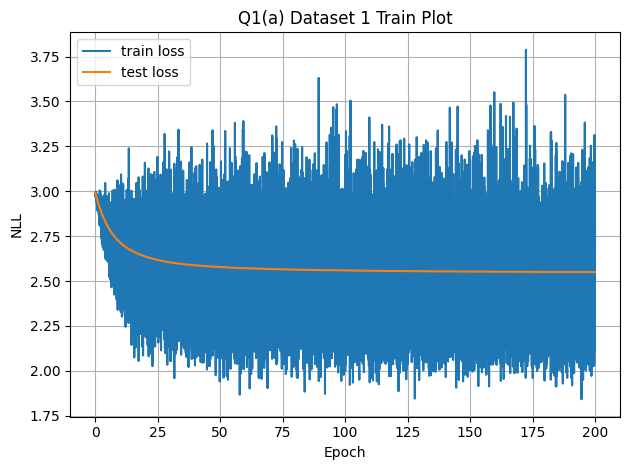

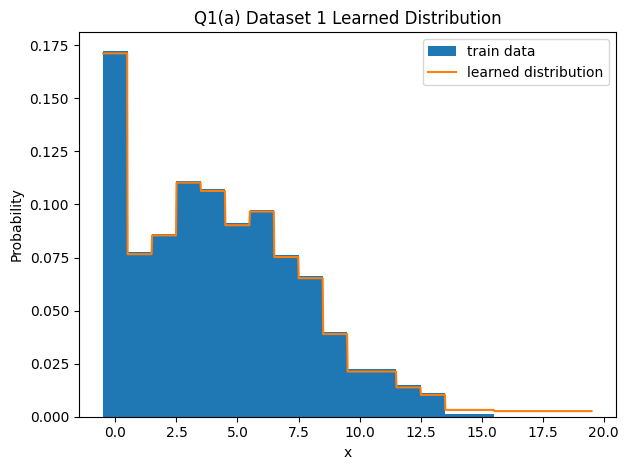

In [6]:
q1_save_results(1, 'a', q1_a)

Final Test Loss: 3.7548


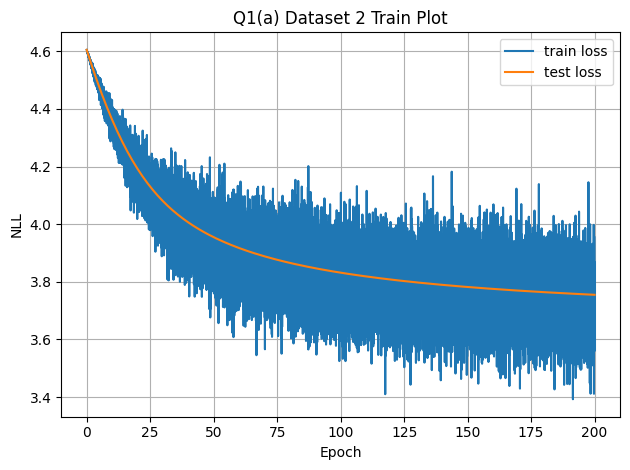

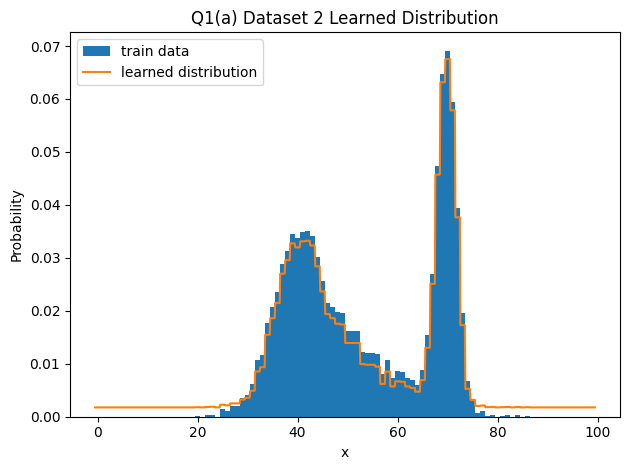

In [7]:
q1_save_results(2, 'a', q1_a)

## Part (b) Fitting Discretized Mixture of Logistics

Let us model $p_\theta(x)$ as a **discretized** mixture of 4 logistics such that $p_\theta(x) = \sum_{i=1}^4 \pi_i[\sigma((x+0.5 - \mu_i)/s_i) - \sigma((x-0.5-\mu_i)/s_i)]$

For the edge case of when $x = 0$, we replace $x-0.5$ by $-\infty$, and for $x = 99$, we replace $x+0.5$ by $\infty$.

You may find the [PixelCNN++](https://arxiv.org/abs/1701.05517) helpful for more information on discretized mixture of logistics.

**Provide the same set of corresponding deliverables as part (a)**

Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [8]:
def q1_b(train_data, test_data, d, dset_id):
    """
    train_data: An (n_train,) numpy array of integers in {0, ..., d-1}
    test_data: An (n_test,) numpy array of integers in {0, .., d-1}
    d: The number of possible discrete values for random variable x
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
             used to set different hyperparameters for different datasets
  
    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (d,) of model probabilities
    """

    train_losses = []
    test_losses = []
    n_components = 4
    n_train = train_data.shape[0]
    n_test = test_data.shape[0]
    test_data = test_data.reshape((n_test, 1))

    max_epochs = 100
    lr = 0.1
    batch_size = 128
    train_data = train_data.reshape((n_train, 1))
    mu = torch.linspace(1, d, n_components, requires_grad=True)
    sigma_log = torch.ones(n_components, requires_grad=True)
    pi_logits = torch.ones(n_components, requires_grad=True)

    def p_theta(x):
        return torch.inner(torch.softmax(pi_logits, 0), (
                torch.where(x >= d - 1, 1, torch.sigmoid((x + 0.5 - mu) / torch.exp(sigma_log))) -
                torch.where(x <= 0, 0, torch.sigmoid((x - 0.5 - mu) / torch.exp(sigma_log)))))

    loss_function = lambda z: (-1 / z.shape[0]) * torch.sum(torch.log(z))

    test_loss = loss_function(p_theta(torch.tensor(test_data)))
    test_losses.append(test_loss.item())

    train_loader = DataLoader(TensorDataset(torch.tensor(train_data)), batch_size=batch_size, shuffle=True)

    for epoch in range(max_epochs):
        for batch in train_loader:
            batch = batch[0]
            probs = p_theta(batch)
            train_loss = loss_function(probs)
            train_losses.append(train_loss.item())
            train_loss.backward()
            with torch.no_grad():
                # step
                mu.copy_(mu - lr * mu.grad)
                sigma_log.copy_(sigma_log - lr * sigma_log.grad)
                pi_logits.copy_(pi_logits - lr * pi_logits.grad)

                # zero grad
                mu.grad.zero_()
                sigma_log.grad.zero_()
                pi_logits.grad.zero_()
        with torch.no_grad():
            test_loss = loss_function(p_theta(torch.tensor(test_data)))
            test_losses.append(test_loss.item())
    return train_losses, test_losses, p_theta(torch.arange(d).reshape((d, 1))).detach().numpy()



### Results

Once you've implemented `q1_b`, execute the cells below to visualize and save your results



Final Test Loss: 2.5621


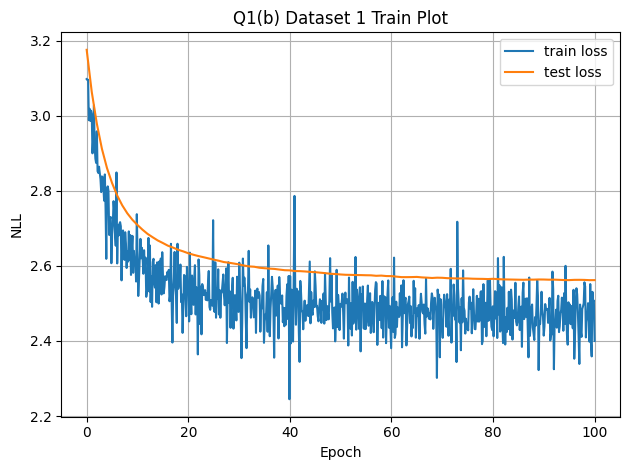

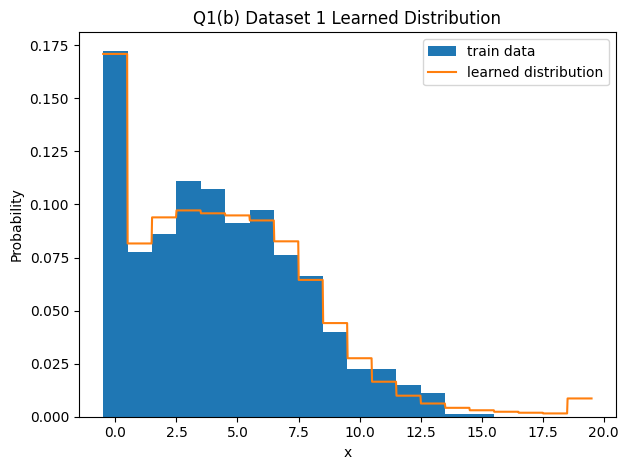

In [9]:
q1_save_results(1, 'b', q1_b)

Final Test Loss: 3.6868


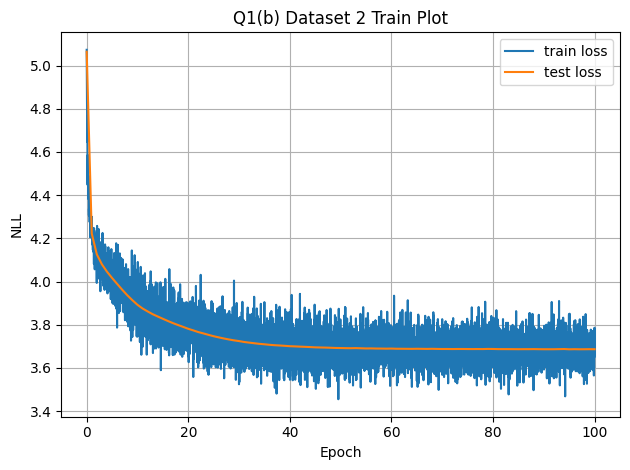

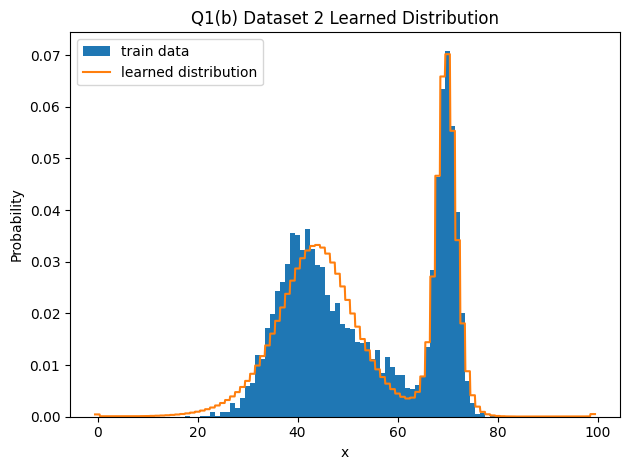

In [10]:
q1_save_results(2, 'b', q1_b)